In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [27]:
# Load the dataset
file_path = "we.csv"  # Change to your file path
df = pd.read_csv(file_path)

In [28]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')


In [29]:
# Handle missing values
## Fill numerical columns with median
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
df[numerical_columns] = df[numerical_columns].apply(lambda x: x.fillna(x.median()))


In [30]:
## Fill categorical columns with mode
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))


In [31]:
# Remove duplicate rows
df = df.drop_duplicates()

In [32]:
# Encode categorical features
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [34]:
# Save LabelEncoders
joblib.dump(label_encoders, "label_encoders.pkl")

['label_encoders.pkl']

In [35]:
# Identify numerical features
df_numeric = df.select_dtypes(include=['number'])
feature_columns = df_numeric.columns.tolist()
feature_columns.remove('Temperature (°C)')  # Exclude target variabl

In [36]:
# Feature Scaling
scaler = StandardScaler()
df[feature_columns] = scaler.fit_transform(df[feature_columns])


In [37]:
# Save the scaler and feature columns
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [38]:
joblib.dump(feature_columns, "feature_columns.pkl")

['feature_columns.pkl']

In [39]:
# Detect and remove outliers using Z-score
def remove_outliers(df, columns, threshold=3):
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df = df[z_scores < threshold]
    return df

df = remove_outliers(df, feature_columns)

# Save the cleaned dataset
df.to_csv("cleaned_we.csv", index=False)


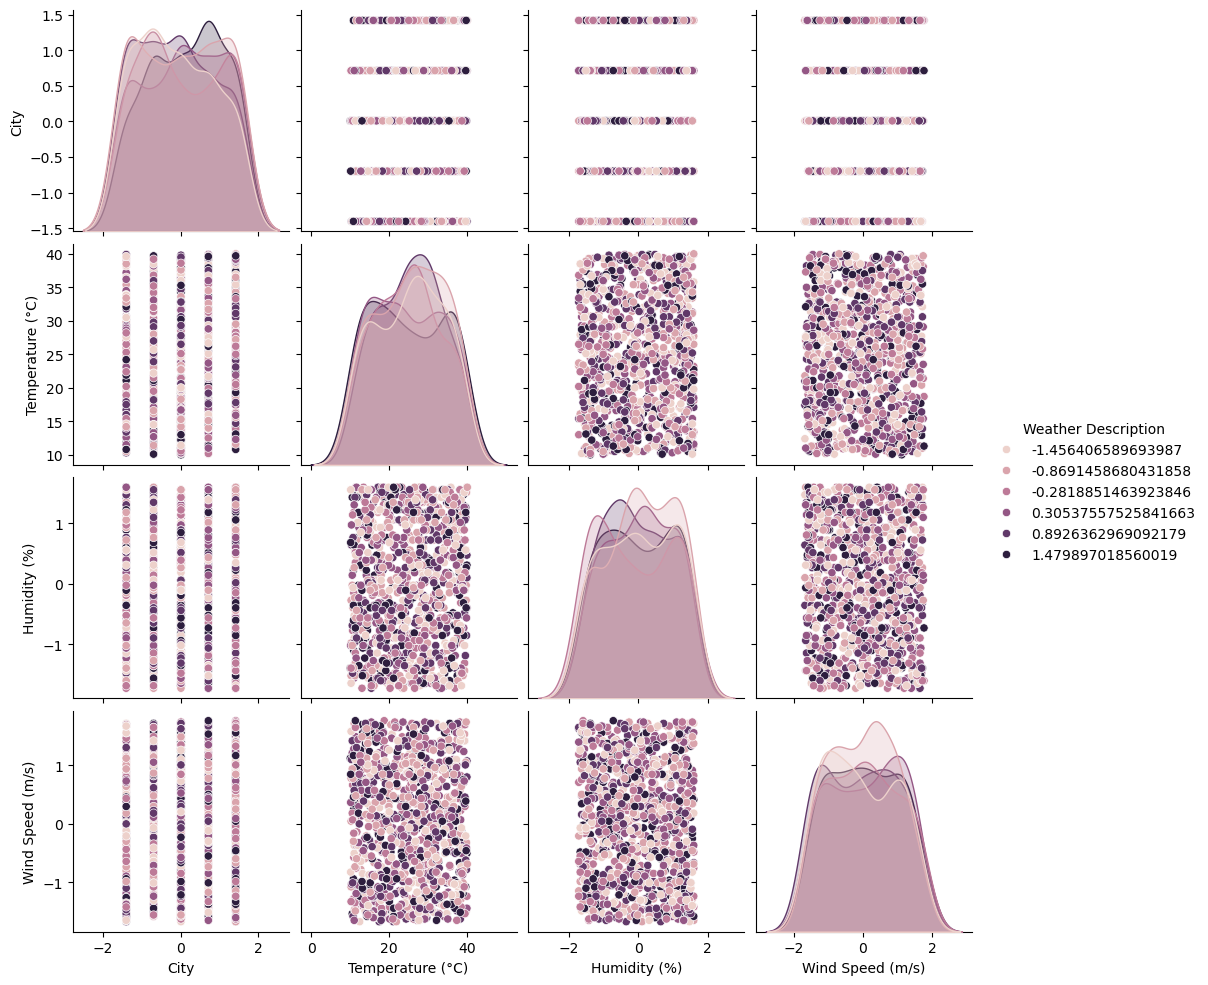

In [40]:
# Visualize relationships
sns.pairplot(df, hue='Weather Description')
plt.show()

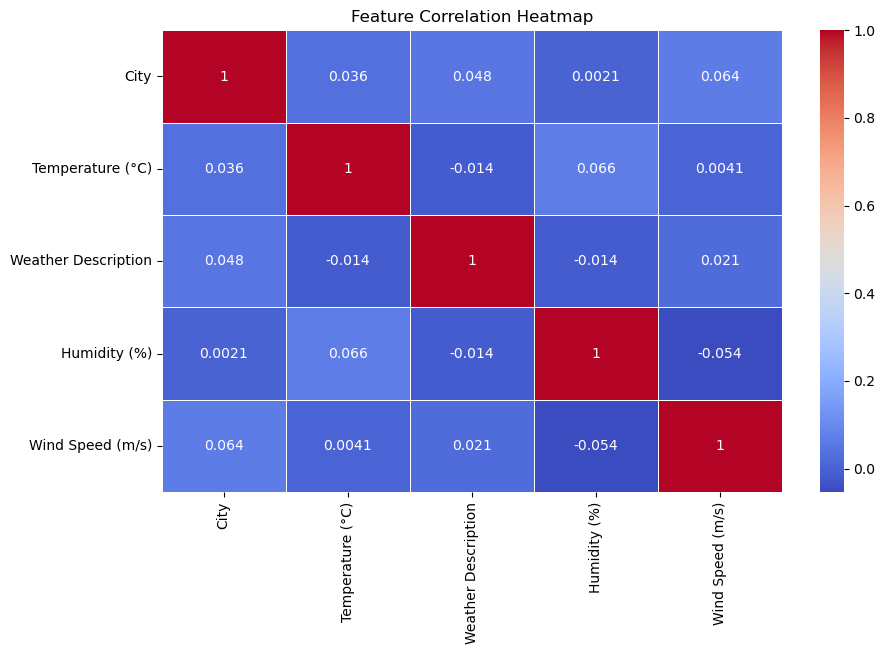

In [41]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

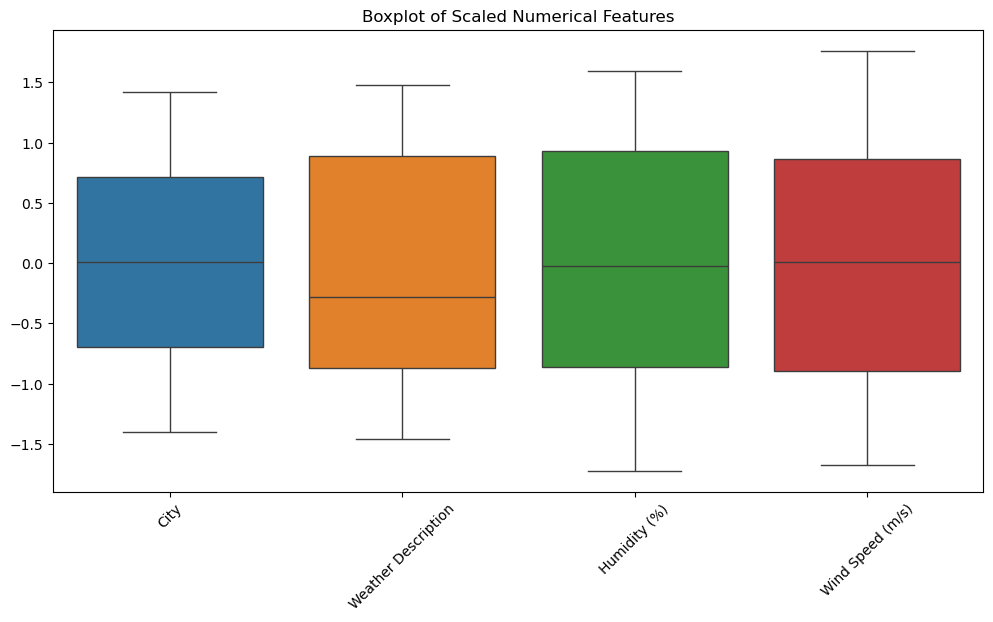

In [43]:
# Boxplot to identify remaining outliers
plt.figure(figsize=(12,6))
sns.boxplot(data=df[feature_columns])
plt.title("Boxplot of Scaled Numerical Features")
plt.xticks(rotation=45)
plt.show()

In [44]:
# Select features and target variable
target = 'Temperature (°C)'
X = df.drop(columns=[target, 'Date'])  # Exclude date from features
y = df[target]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model (Random Forest Regressor)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, "regression_model.pkl")

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:\nMAE: {mae}\nMSE: {mse}\nR² Score: {r2}")

# Baseline Model (Dummy Regressor)
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
dummy_pred = dummy_model.predict(X_test)

# Evaluate baseline model
dummy_mae = mean_absolute_error(y_test, dummy_pred)
dummy_mse = mean_squared_error(y_test, dummy_pred)
dummy_r2 = r2_score(y_test, dummy_pred)

print(f"Baseline Model Performance:\nMAE: {dummy_mae}\nMSE: {dummy_mse}\nR² Score: {dummy_r2}")


Model Performance:
MAE: 7.723111666666667
MSE: 82.18740585944448
R² Score: -0.1395056253524014
Baseline Model Performance:
MAE: 7.249095
MSE: 72.1359488125
R² Score: -0.000144956546657804


In [45]:
# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [46]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_


print("Best Model Parameters:", grid_search.best_params_)

Best Model Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [21]:
joblib.dump(best_model, "best_regression_model.pkl")

['best_regression_model.pkl']

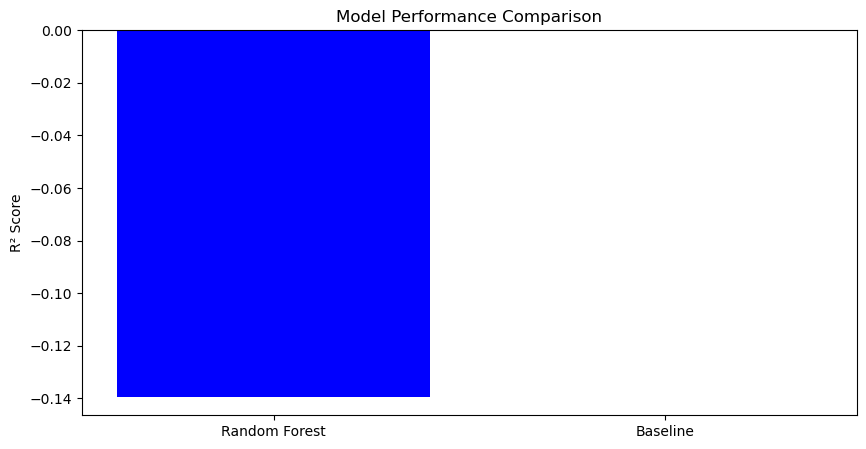

In [24]:
# Visualization of Model vs Baseline
plt.figure(figsize=(10,5))
plt.bar(['Random Forest', 'Baseline'], [r2, dummy_r2], color=['blue', 'red'])
plt.ylabel("R² Score")
plt.title("Model Performance Comparison")
plt.show()

In [25]:
pip install uvicorn
